In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

In [2]:
from langgraph.graph.message import add_messages

class ChatState(TypedDict):

    messages: Annotated[list[BaseMessage], add_messages]

In [3]:

load_dotenv(override=True)
import os


In [4]:
def get_groq_llm():
    return ChatOpenAI(
        model="openai/gpt-oss-20b",
        base_url="https://api.groq.com/openai/v1",
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7, max_tokens=2000
    )

llm = get_groq_llm()

In [5]:
def chat_node(state: ChatState):

    # take user query from state
    messages = state['messages']

    # send to llm
    response = llm.invoke(messages)

    # response store state
    return {'messages': [response]}

In [6]:
graph = StateGraph(ChatState)

# add nodes
graph.add_node('chat_node', chat_node)

graph.add_edge(START, 'chat_node')
graph.add_edge('chat_node', END)

chatbot = graph.compile()

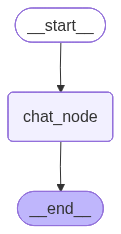

In [7]:
chatbot

In [8]:
initial_state = {
    'messages': [HumanMessage(content='What is the capital of india')]
}

chatbot.invoke(initial_state)['messages'][-1].content


'The capital of India is **New\u202fDelhi**.'

In [9]:
initial_state = {
    'messages': [HumanMessage(content='HI there my name is sachin, How are you doing today?')]
}

chatbot.invoke(initial_state)['messages'][-1].content

'Hello Sachin! I’m doing great—thanks for asking. How about you? Anything interesting on your mind today?'

In [10]:
initial_state = {
    'messages': [HumanMessage(content='Hey do you remember my name?')]
}

chatbot.invoke(initial_state)['messages'][-1].content


'I don’t have any memory of past conversations, so I’m not sure what your name is. Could you let me know? That way I can address you properly!'

# ## Let's add memory


In [11]:
from langgraph.checkpoint.memory import InMemorySaver




In [12]:
graph = StateGraph(ChatState)

# add nodes
graph.add_node('chat_node', chat_node)

graph.add_edge(START, 'chat_node')
graph.add_edge('chat_node', END)




In [13]:
checkpointer = InMemorySaver()

chatbot = graph.compile(checkpointer=checkpointer)

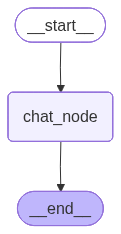

In [14]:
chatbot

In [15]:
config = {"configurable": {"thread_id": "1"}}


In [16]:
initial_state = {
    'messages': [HumanMessage(content='HI there my name is sachin')]
}

chatbot.invoke(initial_state,config=config)['messages'][-1].content

'Hello Sachin! How can I help you today?'

In [17]:
initial_state = {
    'messages': [HumanMessage(content='Do you remember my name?')]
}

chatbot.invoke(initial_state,config=config)['messages'][-1].content


'Yes, you told me your name is **Sachin**.'

In [18]:
config2 = {"configurable": {"thread_id": "2"}}

In [19]:
initial_state = {
    'messages': [HumanMessage(content='Do you remember my name?')]
}

chatbot.invoke(initial_state,config=config2)['messages'][-1].content

'I don’t actually have a memory of past interactions unless you tell me in this conversation. If you’d like me to know your name, just let me know!'